## Setup

### Imports

In [1]:
# General
import os
import re
import shutil

In [2]:
# Web scraping
import urllib.request
from bs4 import BeautifulSoup

In [18]:
# Image proccessing
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Deep learning
from zoo.unet import unet
from pipeline import generator

## Parameters

In [5]:
# Workflow
rescrape = False

In [6]:
# Hyperparameters
BS = 2  # batch size

## Collect Data

In [5]:
if os.path.exists('data/'):
    if rescrape:
        shutil.rmtree('data/')
os.mkdir('data/')

for split in ('train', 'valid', 'test'):
    os.mkdir(f'data/{split}')
    for category in ('sat', 'map'):
        os.mkdir(f'data/{split}/{category}')
        url = 'https://www.cs.toronto.edu/~vmnih/data/mass_buildings/' + \
            f'{split}/{category}/index.html'
        res = urllib.request.urlopen(url)
        soup = BeautifulSoup(res, 'html.parser')
        
        for a in soup.find_all('a', href=True):
            link = a['href']
            name = re.search(r'/([^/]*)$', link).group(1)
            urllib.request.urlretrieve(link, f'data/{split}/{category}/{name}')

## Data Pipeline

In [7]:
train_gen = generator.generator('data/train', BS)
val_gen = generator.generator('data/valid', BS)
test_gen = generator.generator('data/test', BS)

### Visualise Data

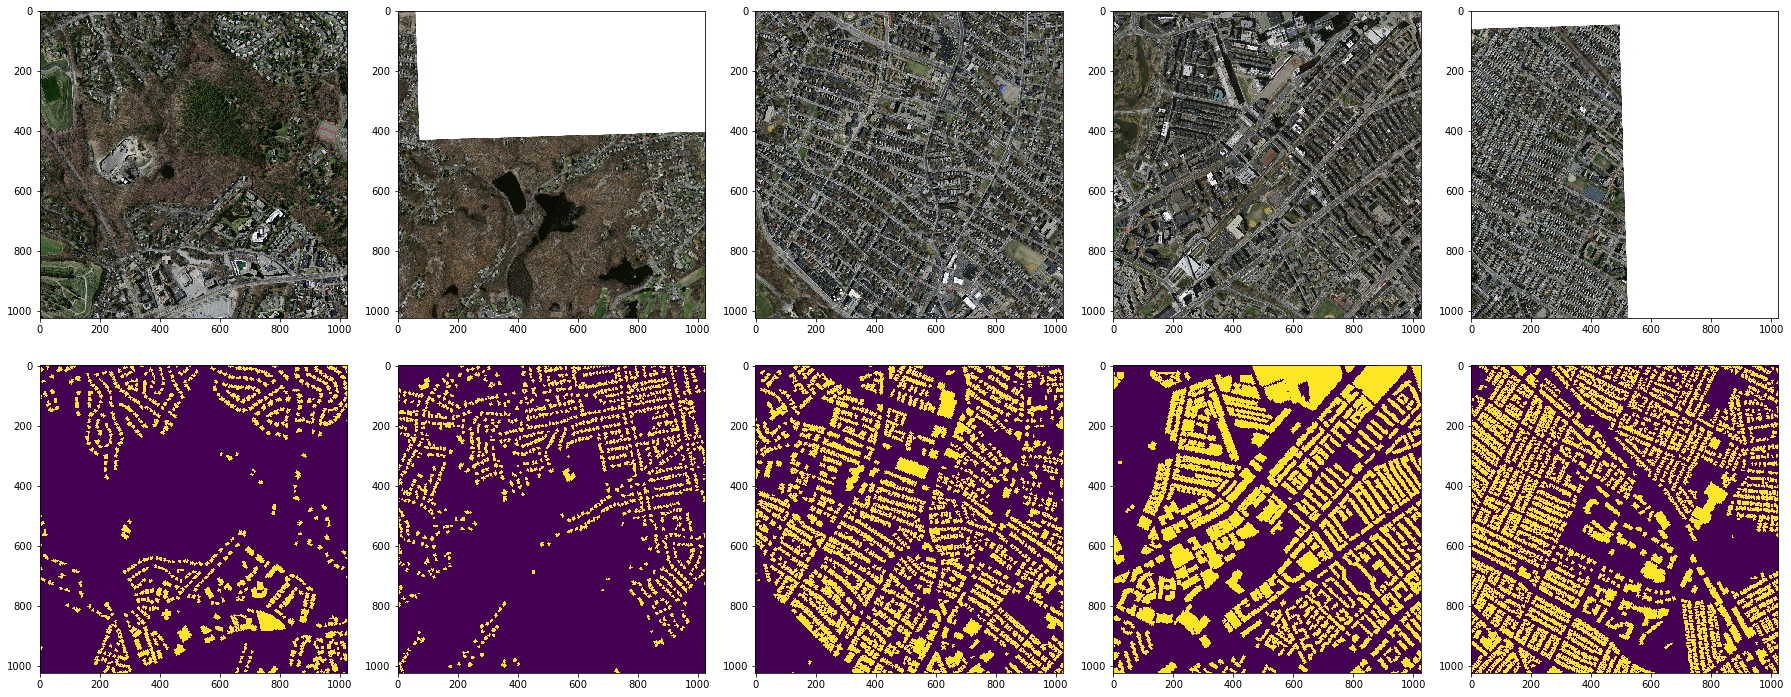

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))
batches = [[], []]
for i in range(5):
    if i >= len(batches[0]):
        new_batch = next(train_gen)
        batches[0].extend(new_batch[0])
        batches[1].extend(new_batch[1])
    img, lab = batches[0][i], batches[1][i]
    axs[0][i].imshow(img)
    axs[1][i].imshow(lab[:,:,0])
fig.tight_layout()
fig.set_facecolor('white')

## Modelling

In [9]:
import tensorflow as tf

In [10]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [11]:
model = unet()

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              patience=3)

callbacks = [reduce_lr, early_stopping]

In [13]:
history = model.fit(
    train_gen,
    steps_per_epoch=8,
    epochs=1000,
    verbose=1,
    callbacks=callbacks,
    validation_data=val_gen,
    validation_steps=8
)

Epoch 1/1000
8/8 [==============================] - 4s 489ms/step - loss: 0.6243 - accuracy: 0.7225 - val_loss: 0.5191 - val_accuracy: 0.8221 - lr: 0.0010
Epoch 2/1000
8/8 [==============================] - 4s 447ms/step - loss: 0.5734 - accuracy: 0.8096 - val_loss: 0.5869 - val_accuracy: 0.8157 - lr: 0.0010
Epoch 3/1000
8/8 [==============================] - 4s 457ms/step - loss: 0.5759 - accuracy: 0.7909 - val_loss: 0.5114 - val_accuracy: 0.8441 - lr: 0.0010
Epoch 4/1000
8/8 [==============================] - 4s 461ms/step - loss: 0.5575 - accuracy: 0.8079 - val_loss: 0.5105 - val_accuracy: 0.8320 - lr: 0.0010
Epoch 5/1000
8/8 [==============================] - 4s 454ms/step - loss: 0.5778 - accuracy: 0.7701 - val_loss: 0.5665 - val_accuracy: 0.8113 - lr: 0.0010
Epoch 6/1000
8/8 [==============================] - 4s 444ms/step - loss: 0.5831 - accuracy: 0.7676 - val_loss: 0.5417 - val_accuracy: 0.8113 - lr: 0.0010
Epoch 7/1000
8/8 [==============================] - 4s 446ms/step - lo

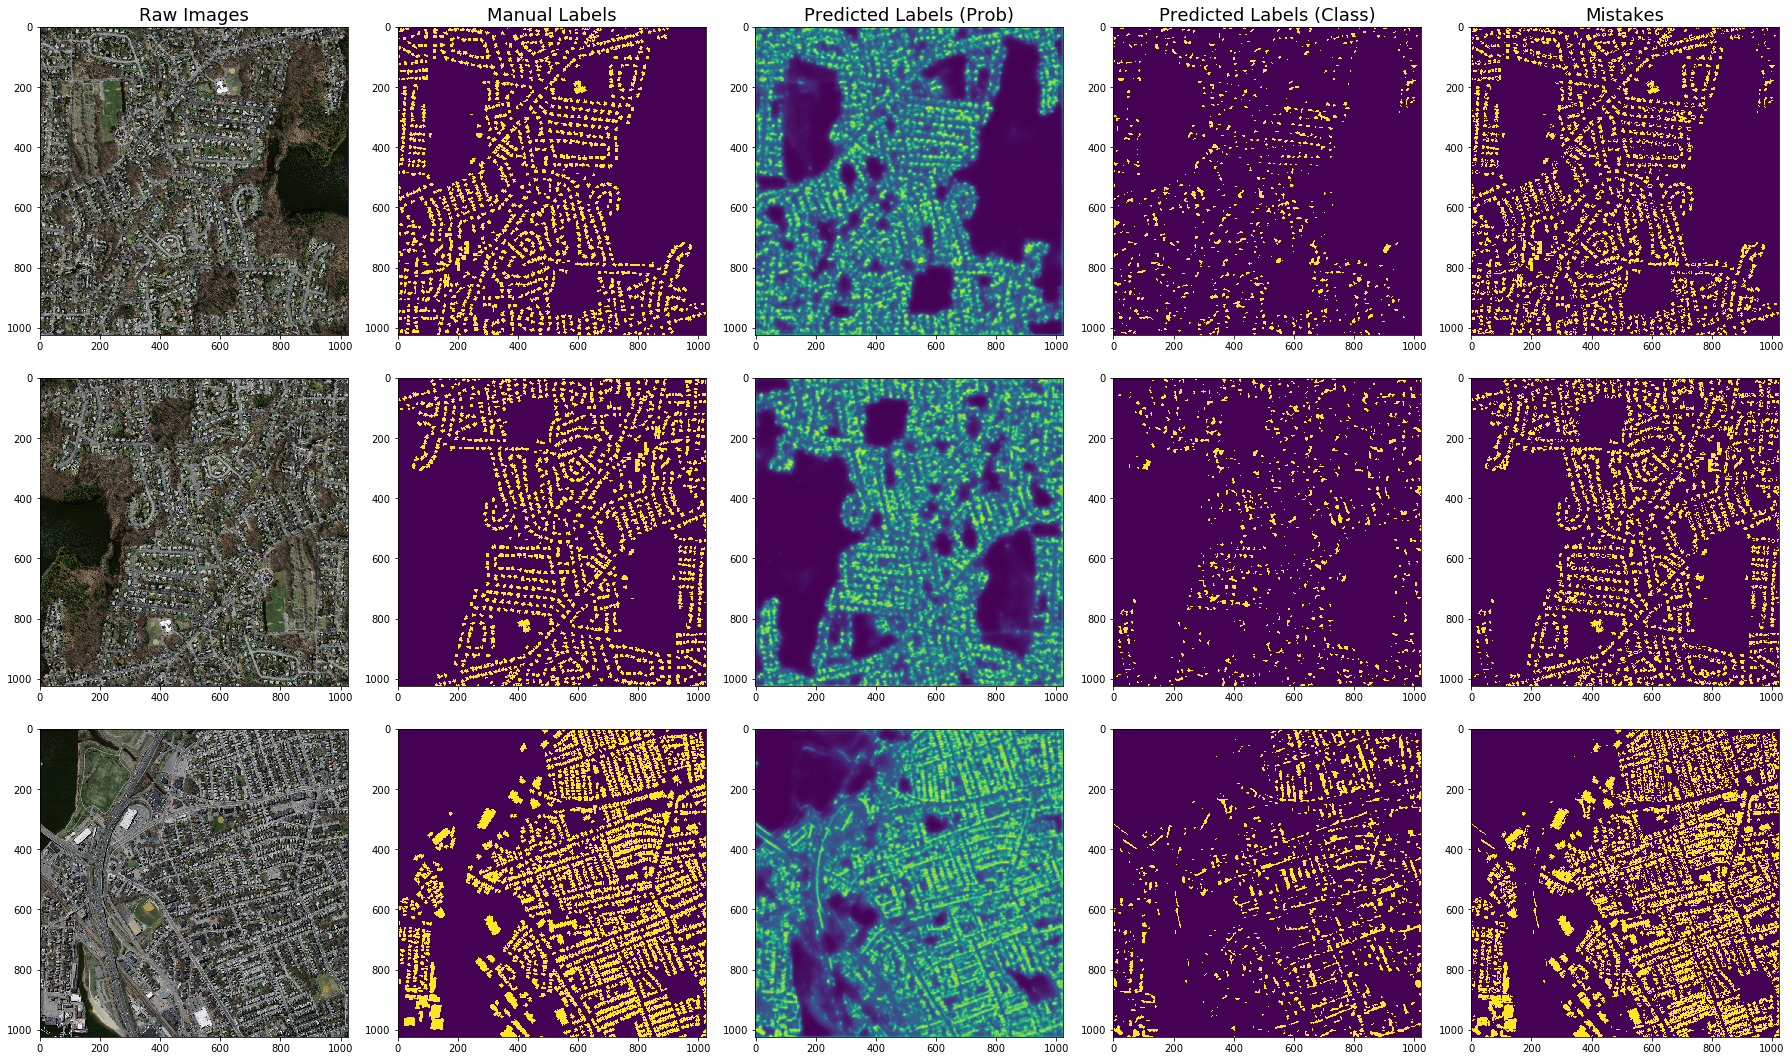

In [22]:
fig, axs = plt.subplots(3, 5, figsize=(25, 15))
batches = [[], []]
for i in range(3):
    if i >= len(batches[0]):
        new_batch = next(val_gen)
        batches[0].extend(new_batch[0])
        batches[1].extend(new_batch[1])
    img, lab = batches[0][i], batches[1][i]
    axs[i][0].imshow(img, cmap='bone')
    axs[i][1].imshow(lab[:,:,0])
    pred = model.predict(img.reshape(1, 1024, 1024, 3)).reshape(1024, 1024)
    axs[i][2].imshow(pred)
    axs[i][3].imshow(pred > 0.5)
    axs[i][4].imshow(np.logical_xor(pred > 0.5, lab[:,:,0]))
# set column headers
cols = ['Raw Images', 'Manual Labels',
        'Predicted Labels (Prob)', 'Predicted Labels (Class)',
        'Mistakes']
for ax, col in zip(axs[0], cols):
    ax.set_title(col, fontsize=18)
fig.tight_layout()
fig.set_facecolor('white')